In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [8]:
df = yf.download('MSFT', start='2020-01-01', end='2024-12-31')
df = df[['Close']].copy()
df.columns = ['price']
df.dropna(inplace=True)
df.head()

C:\Users\Alqama\AppData\Local\Temp\ipykernel_28124\2800827018.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('MSFT', start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


,price
Date,
2020-01-02,153.042297
2020-01-03,151.136642
2020-01-06,151.527344
2020-01-07,150.145691
2020-01-08,152.537292


In [11]:
print(type(df['price']))

<class 'pandas.core.series.Series'>


In [13]:
# Calculation of z-score deviations from  a moving average
window = 20 # for each date in the dataset, it looks back at the previous 20 days of price data to calculate: 20-day moving average of the stock price of 20-day standard deviation and 20-day standard deviation (volatility)

df['mean'] = df['price'].rolling(window).mean()
df['std'] = df['price'].rolling(window).std()
df['z_score'] = (df['price'] - df['mean']) / df['std']

df['position'] = np.where(df['z_score'] < -1, 1, 0) # Buy
df['position'] = np.where(df['z_score'] > 1, -1, df['position']) # sell

df.dropna(inplace=True)

In [15]:
# backtest run, assuming an investment of $100,000 with full exposure on each signal

initial_cash = 100_000
df['returns'] = df['price'].pct_change()
df['strategy'] = df['position'].shift(1) * df['returns']
df.dropna(inplace=True)

df['equity_curve'] = initial_cash * (1 + df['strategy']).cumprod()
df['buy_hold'] = initial_cash * (1 + df['returns']).cumprod()

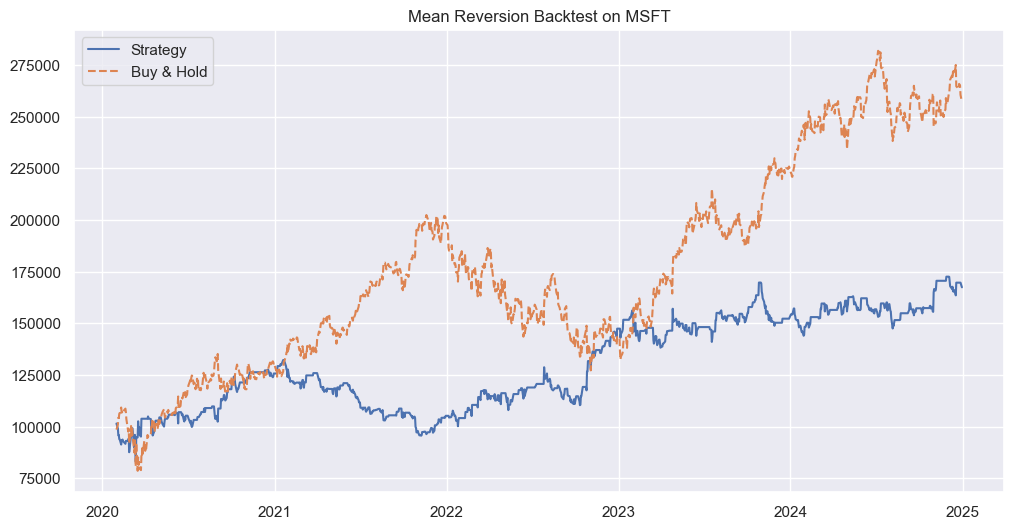

In [17]:
ticker = 'MSFT'
plt.figure(figsize=(12, 6))
plt.plot(df['equity_curve'], label='Strategy')
plt.plot(df['buy_hold'], label='Buy & Hold', linestyle='--')
plt.title(f'Mean Reversion Backtest on {ticker}')
plt.legend()
plt.show()

In [12]:
# defining a backtesting class

class BackTestEngine:
    def __init__(self, ticker, start_date, end_date, window=20, initial_cash = 100_000):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date =  end_date
        self.window = window
        self.initial_cash = initial_cash
        self.results = None
        self._prepare_data()

    def _prepare_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
        df.columns = ['price']
        df['mean'] = df['price'].rolling(self.window).mean()
        df['std'] =  df['price'].rolling(self.window).std()
        df['z_score'] = (df['price'] - df['mean']) / df['std']
        df['position'] = np.where(df['z_score'] < -1, 1, 0) # Buy
        df['position'] = np.where(df['z_score'] > 1, -1, df['position'])
        df['returns'] = df['price'].pct_change()
        df['strategy'] = df['position'].shift(1) * df['returns']
        df.dropna(inplace=True)
        df['equity_curve'] = self.initial_cash * (1 + df['strategy']).cumprod()
        df['buy_hold'] = self.initial_cash * (1 + df['returns']).cumprod()
        self.results = df

    def plot_performance(self):
        if self.results is None:
            print("No results to plot")
            return
        self.results[['equity_curve', 'buy_hold']].plot(figsize=(12, 6), title = f"{self.ticker} Mean Reversion Backtest")
        plt.show()

C:\Users\Alqama\AppData\Local\Temp\ipykernel_13968\2222214421.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


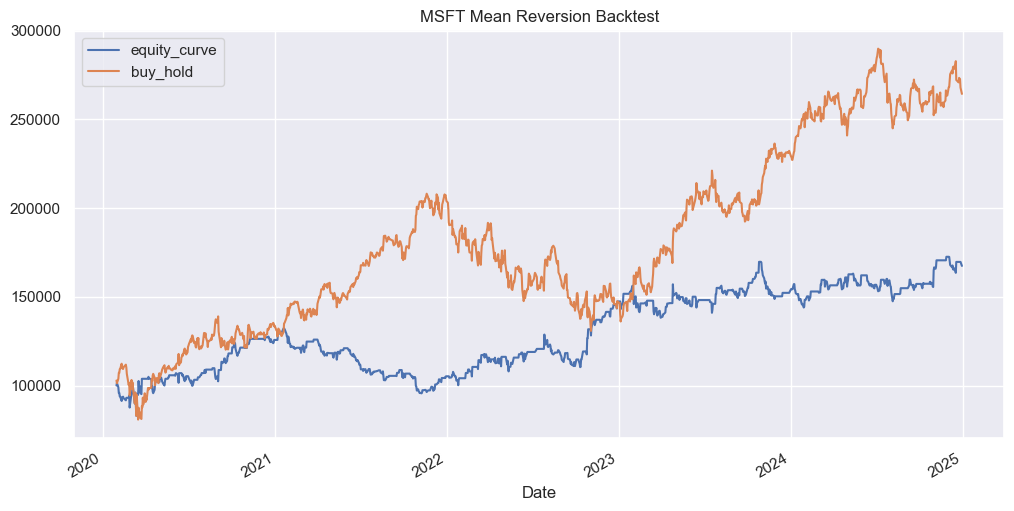

In [15]:
bt = BackTestEngine('MSFT', '2020-01-01', '2024-12-31', window=20)
bt.plot_performance()

In [17]:
# Updation of BacktestEngine class to allow for specifying entry and exit thresholds, by adding Z-Score Threshold Parameters
class BackTestEngine:
    def __init__(self, ticker, start_date, end_date, window=20, z_entry = 1.0, z_exit = 0.0, initial_cash = 100_000):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date =  end_date
        self.window = window
        self.z_entry = z_entry
        self.z_exit =  z_exit
        self.initial_cash = initial_cash
        self.results = None
        self._prepare_data()

    def _prepare_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
        df.columns = ['price']
        df['mean'] = df['price'].rolling(self.window).mean()
        df['std'] =  df['price'].rolling(self.window).std()
        df['z_score'] = (df['price'] - df['mean']) / df['std']

        # signal creation
        df['position'] = 0
        df.loc[df['z_score'] < -self.z_entry, 'position'] = 1
        df.loc[df['z_score'] > self.z_entry, 'position'] = -1
        df.loc[abs(df['z_score']) < self.z_exit, 'position'] = 0

        df['returns'] = df['price'].pct_change()
        df['strategy'] = df['position'].shift(1) * df['returns']
        df.dropna(inplace=True)
        df['equity_curve'] = self.initial_cash * (1 + df['strategy']).cumprod()
        df['buy_hold'] = self.initial_cash * (1 + df['returns']).cumprod()
        self.results = df

    def plot_performance(self):
        if self.results is None:
            print("No results to plot")
            return
        self.results[['equity_curve', 'buy_hold']].plot(figsize=(12, 6), title = f"{self.ticker} Mean Reversion Backtest")
        plt.show()

C:\Users\Alqama\AppData\Local\Temp\ipykernel_13968\837531540.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


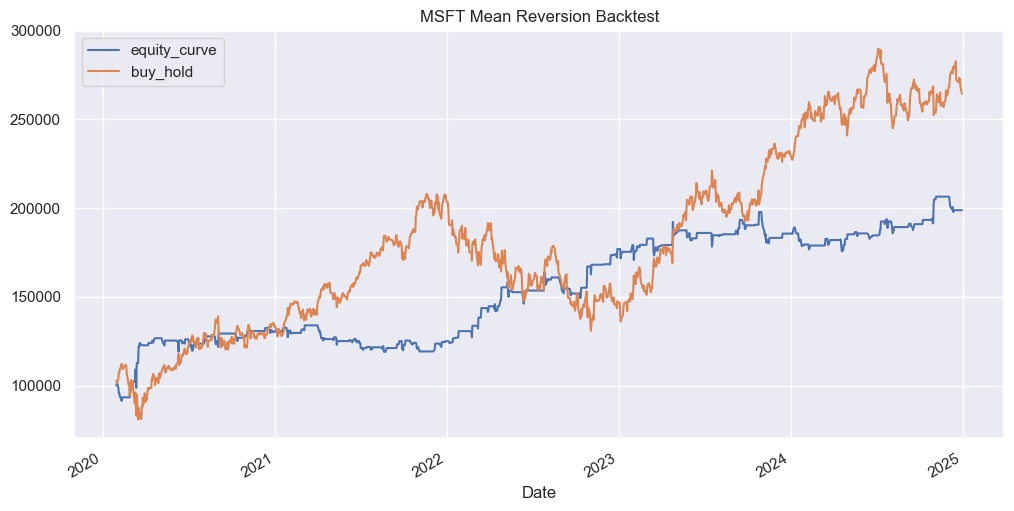

In [19]:
bt = BackTestEngine('MSFT', '2020-01-01', '2024-12-31', window=20, z_entry = 1.5, z_exit = 0.5)
bt.plot_performance()

In [19]:
# Strategy interface creation to make the backtesting engine Strategy-Agnostic
class Strategy:
    def __init__(self, window = 20):
        self.window = window

    def generate_signals(self, df):
        raise NotImplementedError("generate_signals() must be implemented by the subclass")

In [21]:
class MeanReversionStrategy(Strategy):
    def __init__(self, window = 20, z_entry = 1.0, z_exit = 0.0):
        super().__init__(window)
        self.z_entry = z_entry
        self.z_exit = z_exit

    def generate_signals(self, df):
        df['mean'] = df['price'].rolling(self.window).mean()
        df['std'] =  df['price'].rolling(self.window).std()
        df['z_score'] = (df['price'] - df['mean']) / df['std']
        df['position'] = 0
        df.loc[df['z_score'] < -self.z_entry, 'position'] = 1
        df.loc[df['z_score'] > self.z_entry, 'position'] = -1
        df.loc[abs(df['z_score']) < self.z_exit, 'position'] = 0
        return df

In [23]:
# backtesting updation to accept a strategy object
class BackTestEngine:
    def __init__(self, ticker, start_date, end_date, strategy, initial_cash = 100_000):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date =  end_date
        self.strategy = strategy
        self.initial_cash = initial_cash
        self.results = None
        self._prepare_data()

    def _prepare_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
        df.columns = ['price']
        df.dropna(inplace=True)

        df = self.strategy.generate_signals(df)

        df['returns'] = df['price'].pct_change()
        df['strategy'] = df['position'].shift(1) * df['returns']
        df.dropna(inplace=True)
        
        df['equity_curve'] = self.initial_cash * (1 + df['strategy']).cumprod()
        df['buy_hold'] = self.initial_cash * (1 + df['returns']).cumprod()
        self.results = df

    def plot_performance(self):
        if self.results is None:
            print("No results to plot.")
            return
        self.results[['equity_curve', 'buy_hold']].plot(figsize=(12, 6), title = f"{self.ticker} Strategy Backtest")
        plt.show()

C:\Users\Alqama\AppData\Local\Temp\ipykernel_28124\847532507.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


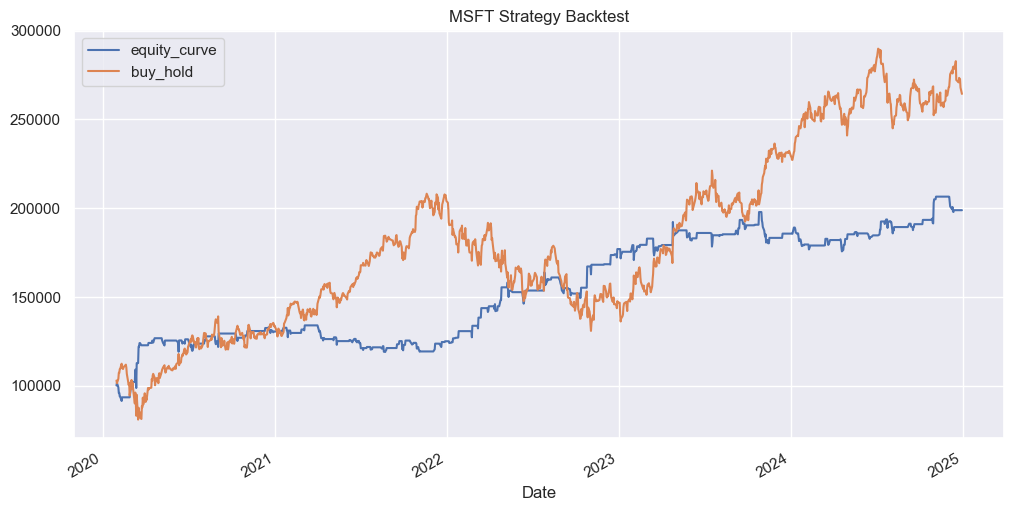

In [25]:
strategy = MeanReversionStrategy(window = 20, z_entry = 1.5, z_exit = 0.5)
bt = BackTestEngine('MSFT', '2020-01-01', '2024-12-31', strategy)
bt.plot_performance()

In [27]:
# Let the above backtesting engine accept the momentum strategy
class MomentumStrategy(Strategy):
    def __init__(self, window = 20):
        super().__init__(window)

    def generate_signals(self, df):
        df['ma'] = df['price'].rolling(self.window).mean()
        df['position'] = 0
        df.loc[df['price'] > df['ma'], 'position'] = 1
        df.loc[df['price'] < df['ma'], 'position'] = -1
        return df

C:\Users\Alqama\AppData\Local\Temp\ipykernel_13968\847532507.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.ticker, start = self.start_date, end = self.end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed


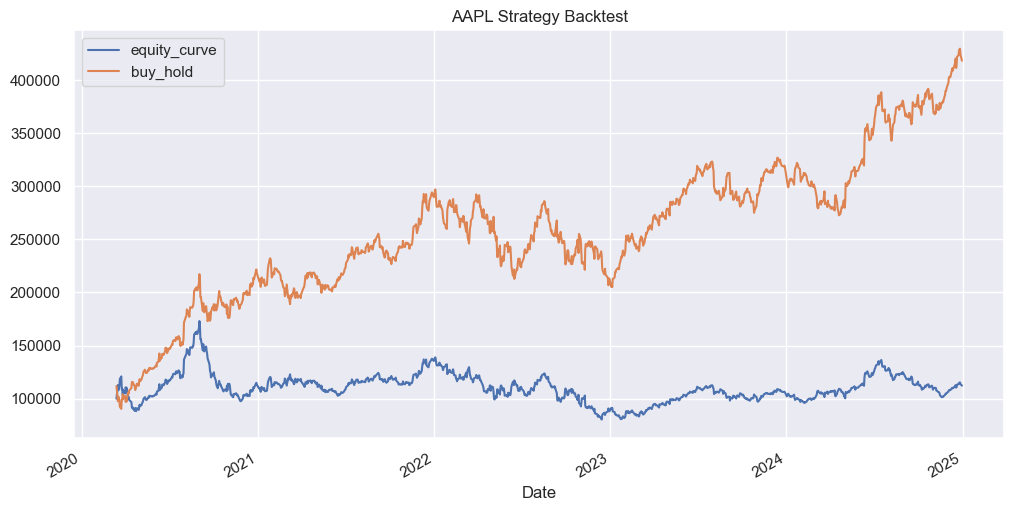

In [31]:
momentum_strategy = MomentumStrategy(window = 50)
bt_momentum = BackTestEngine('AAPL', '2020-01-01', '2024-12-31', strategy = momentum_strategy)
bt_momentum.plot_performance()